# MLP MODEL- PARKING OCCUPANCY PREDICTOR


## 1 Initial preparation:

- **Define the goal:**
Parking Occupancy Predictor


- **Preparing the data:**
We are going to use a 80% for training and the other 20% for testing. We will use regression because we're going to predict a number.

- **Input and Output dimension:**
Our input array (X) will consist of the following data: Month, Day, Day of the Week, Hour, and Minute. The output (y) will be a the parking occupancy.

- **Model:**
We chose an MLP (Multilayer Perceptron) because it is well-suited for handling regression problems with multiple input features. Since our input consists of temporal data (Month, Day, Day of the Week, Hour, and Minute), which does not have a strict sequential relationship but is instead feature-based, the MLP can efficiently learn patterns and relationships between these features to predict the parking occupancy.

###Import && Transform data

In [ ]:
!pip install torch torchvision torchaudio
!pip install pandas numpy matplotlib


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


###Data Preparation

In [ ]:
data = pd.read_csv('data.csv', parse_dates=['DateTime'])

data = data.sort_values('DateTime')

data['Net'] = data['Event'].map({'Entry': 1, 'Exit': -1})

data = data.set_index('DateTime')

net_per_minute = data['Net'].resample('1T').sum().fillna(0)

cars_over_time = net_per_minute.cumsum()

time_series = pd.DataFrame({'Cars': cars_over_time})

time_series['Cars'] = time_series['Cars'].fillna(method='ffill').fillna(0)

time_series['Month'] = time_series.index.month
time_series['Day'] = time_series.index.day
time_series['DayOfWeek'] = time_series.index.dayofweek
time_series['Hour'] = time_series.index.hour
time_series['Minute'] = time_series.index.minute

features = ['Month', 'Day', 'DayOfWeek', 'Hour', 'Minute']
target = 'Cars'

from sklearn.preprocessing import MinMaxScaler

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

X = scaler_features.fit_transform(time_series[features])
y = scaler_target.fit_transform(time_series[[target]])

<ipython-input-6-ee4da00b35ee>:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  net_per_minute = data['Net'].resample('1T').sum().fillna(0)
<ipython-input-6-ee4da00b35ee>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series['Cars'] = time_series['Cars'].fillna(method='ffill').fillna(0)


###Preparing Training & Testing Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

###Model definition


In [ ]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

input_size = X_train.shape[1]
model = RegressionModel(input_size=input_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        epoch_val_loss = val_running_loss / len(test_loader)
        val_losses.append(epoch_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
    return train_losses, val_losses

###Training Model & Save

Epoch [1/20], Training Loss: 0.0630, Validation Loss: 0.0537
Epoch [2/20], Training Loss: 0.0452, Validation Loss: 0.0390
Epoch [3/20], Training Loss: 0.0371, Validation Loss: 0.0352
Epoch [4/20], Training Loss: 0.0329, Validation Loss: 0.0327
Epoch [5/20], Training Loss: 0.0289, Validation Loss: 0.0287
Epoch [6/20], Training Loss: 0.0262, Validation Loss: 0.0258
Epoch [7/20], Training Loss: 0.0247, Validation Loss: 0.0242
Epoch [8/20], Training Loss: 0.0236, Validation Loss: 0.0227
Epoch [9/20], Training Loss: 0.0227, Validation Loss: 0.0226
Epoch [10/20], Training Loss: 0.0220, Validation Loss: 0.0218
Epoch [11/20], Training Loss: 0.0213, Validation Loss: 0.0210
Epoch [12/20], Training Loss: 0.0208, Validation Loss: 0.0217
Epoch [13/20], Training Loss: 0.0203, Validation Loss: 0.0193
Epoch [14/20], Training Loss: 0.0200, Validation Loss: 0.0184
Epoch [15/20], Training Loss: 0.0197, Validation Loss: 0.0201
Epoch [16/20], Training Loss: 0.0194, Validation Loss: 0.0185
Epoch [17/20], Tr

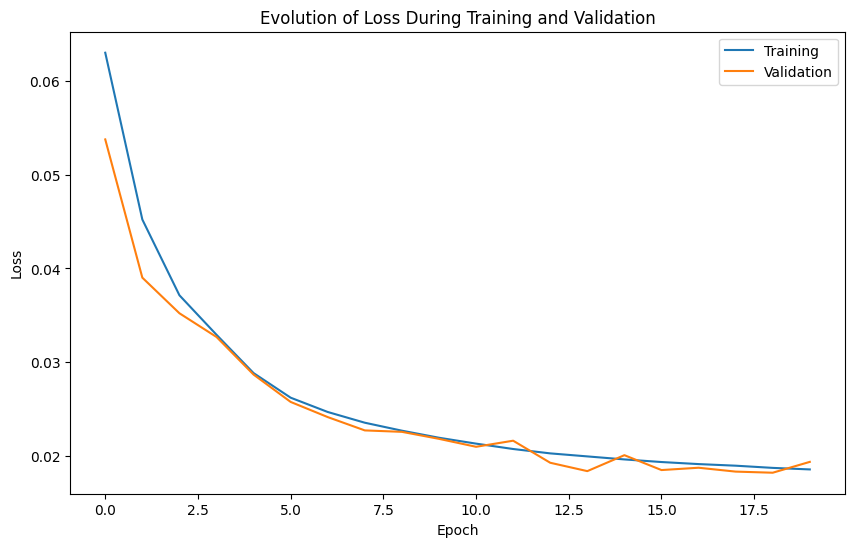

In [ ]:
num_epochs = 20
train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of Loss During Training and Validation')
plt.legend()
plt.savefig("training_validation_loss.png")
plt.show()

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs
}, 'checkpoint_regression.pth')

###Confusion Matrix


<ipython-input-10-a4e1905728f6>:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_period = df_results.groupby('Period').agg({


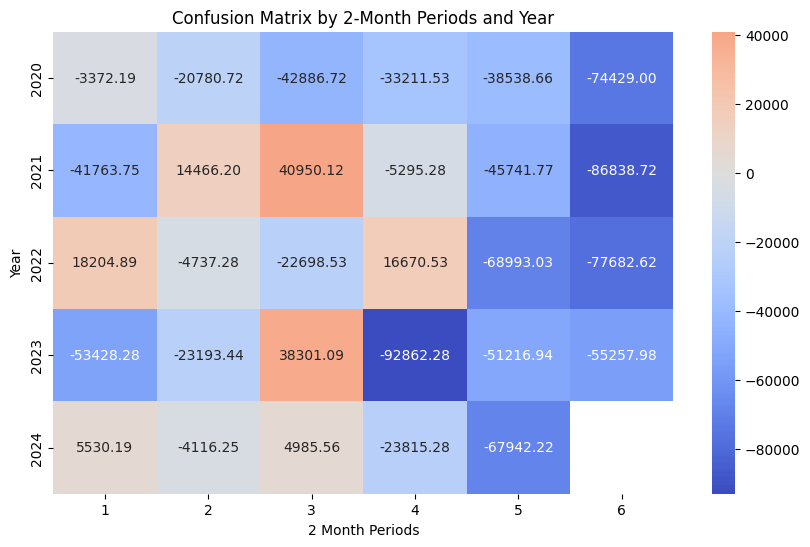

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, time_series.index, test_size=0.2, shuffle=True
)

X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def plot_two_month_error_heatmap(model, data_loader, date_series):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    predictions = []
    true_labels = []
    dates = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1, 1)
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().cpu().numpy())
            true_labels.extend(labels.squeeze().cpu().numpy())
            batch_size = labels.size(0)
            dates.extend(date_series[idx * batch_size : idx * batch_size + batch_size])

    predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    true_labels = scaler_target.inverse_transform(np.array(true_labels).reshape(-1, 1)).flatten()
    dates = pd.to_datetime(dates)

    df_results = pd.DataFrame({
        'DateTime': dates,
        'Predictions': predictions,
        'TrueLabels': true_labels
    })

    start_date = '2020-01-01'
    end_date = '2024-11-30'

    period_ranges = pd.date_range(start=start_date, end=end_date, freq='2MS')

    period_labels = []
    for i in range(len(period_ranges)-1):
        period_start = period_ranges[i].strftime('%Y-%m')
        period_end = (period_ranges[i+1] - pd.Timedelta(days=1)).strftime('%Y-%m')
        period_labels.append(f'{period_start} a {period_end}')

    df_results['Period'] = pd.cut(df_results['DateTime'], bins=period_ranges, labels=period_labels, right=False)

    df_results = df_results.dropna(subset=['Period'])

    df_period = df_results.groupby('Period').agg({
        'Predictions': 'sum',
        'TrueLabels': 'sum'
    }).reset_index()
    df_period['Error'] = df_period['Predictions'] - df_period['TrueLabels']

    df_period['Year'] = df_period['Period'].apply(lambda x: int(x[:4]))
    df_period['PeriodNum'] = df_period.groupby('Year').cumcount()+1

    # Crear tabla pivot para el mapa de calor
    error_pivot = df_period.pivot(index='Year', columns='PeriodNum', values='Error')

    # Graficar el mapa de calor
    plt.figure(figsize=(10, 6))
    sns.heatmap(error_pivot, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.xlabel('2 Month Periods')
    plt.ylabel('Year')
    plt.title('Confusion Matrix by 2-Month Periods and Year')
    plt.show()

plot_two_month_error_heatmap(model, test_loader, idx_test)


###Normalized Confusion Matrix


<ipython-input-11-580504d69898>:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_period = df_results.groupby('Period').agg({


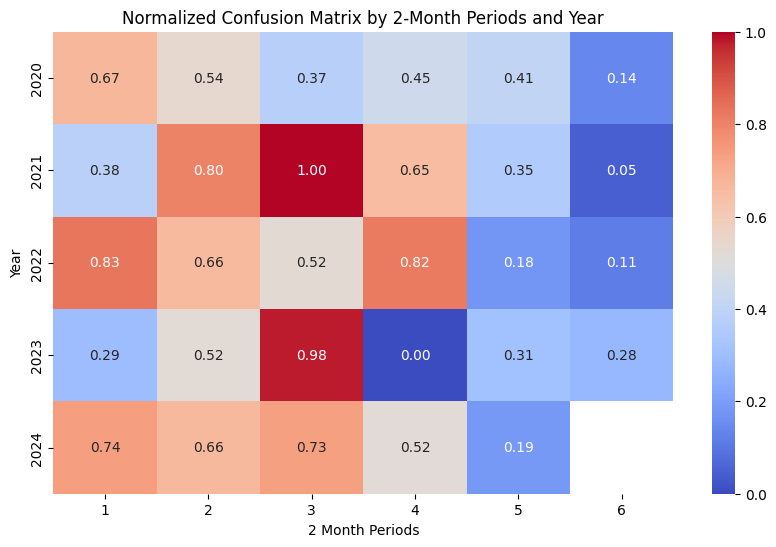

In [ ]:
def plot_two_month_normalized_error_heatmap(model, data_loader, date_series):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    predictions = []
    true_labels = []
    dates = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1, 1)
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().cpu().numpy())
            true_labels.extend(labels.squeeze().cpu().numpy())
            batch_size = labels.size(0)
            dates.extend(date_series[idx * batch_size : idx * batch_size + batch_size])

    predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    true_labels = scaler_target.inverse_transform(np.array(true_labels).reshape(-1, 1)).flatten()
    dates = pd.to_datetime(dates)

    df_results = pd.DataFrame({
        'DateTime': dates,
        'Predictions': predictions,
        'TrueLabels': true_labels
    })

    start_date = '2020-01-01'
    end_date = '2024-11-30'

    period_ranges = pd.date_range(start=start_date, end=end_date, freq='2MS')

    period_labels = []
    for i in range(len(period_ranges)-1):
        period_start = period_ranges[i].strftime('%Y-%m')
        period_end = (period_ranges[i+1] - pd.Timedelta(days=1)).strftime('%Y-%m')
        period_labels.append(f'{period_start} a {period_end}')

    df_results['Period'] = pd.cut(df_results['DateTime'], bins=period_ranges, labels=period_labels, right=False)

    df_results = df_results.dropna(subset=['Period'])

    df_period = df_results.groupby('Period').agg({
        'Predictions': 'sum',
        'TrueLabels': 'sum'
    }).reset_index()
    df_period['Error'] = df_period['Predictions'] - df_period['TrueLabels']

    error_min = df_period['Error'].min()
    error_max = df_period['Error'].max()
    df_period['NormalizedError'] = (df_period['Error'] - error_min) / (error_max - error_min)

    df_period['Year'] = df_period['Period'].apply(lambda x: int(x[:4]))
    df_period['PeriodNum'] = df_period.groupby('Year').cumcount()+1

    error_pivot = df_period.pivot(index='Year', columns='PeriodNum', values='NormalizedError')

    plt.figure(figsize=(10, 6))
    sns.heatmap(error_pivot, annot=True, fmt='.2f', cmap='coolwarm', center=0.5)
    plt.xlabel('2 Month Periods')
    plt.ylabel('Year')
    plt.title('Normalized Confusion Matrix by 2-Month Periods and Year')
    plt.show()

plot_two_month_normalized_error_heatmap(model, test_loader, idx_test)


###Save Scaler


In [ ]:
import joblib
joblib.dump(scaler_features, 'scaler_features.pkl')
joblib.dump(scaler_target, 'scaler_target.pkl')

['scaler_target.pkl']